<a href="https://colab.research.google.com/github/Samarth-991/TimeSeries/blob/master/Time_Series_PowerConsumptionAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Facebook's Prophet

Hourly Time Series Forecasting using Facebook's Prophet

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In this notebook we will use facebook's prophet package to forecast hourly energy use.

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the PJM East which has data from 2002-2018 for the entire east region.

In [59]:
# Upoading the data https://www.kaggle.com/robikscube/hourly-energy-consumption
pjme = pd.read_csv('/content/PJME_hourly.csv', index_col=[0], parse_dates=[0])
pjme

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


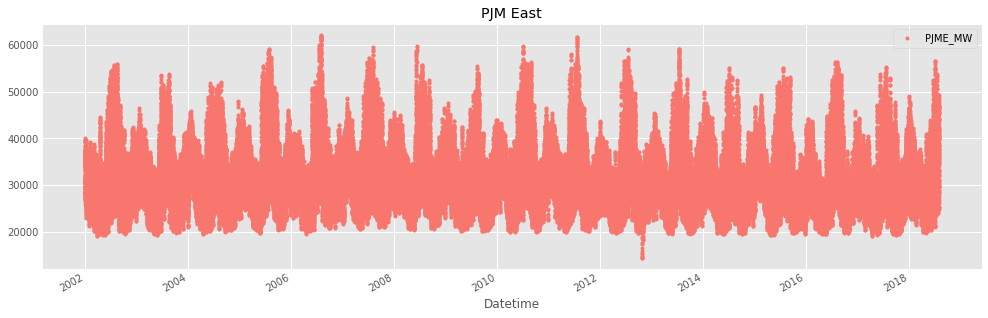

In [60]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')
plt.show()

In [61]:
def create_features(df,label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek']=df['date'].dt.dayofweek
    df['quarter']=df['date'].dt.quarter
    df['month']=df['date'].dt.month
    df['year']=df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [62]:
X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)
features_and_target

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,20,0,1,1,2018,1,1,1,44284.0
2018-01-01 21:00:00,21,0,1,1,2018,1,1,1,43751.0
2018-01-01 22:00:00,22,0,1,1,2018,1,1,1,42402.0


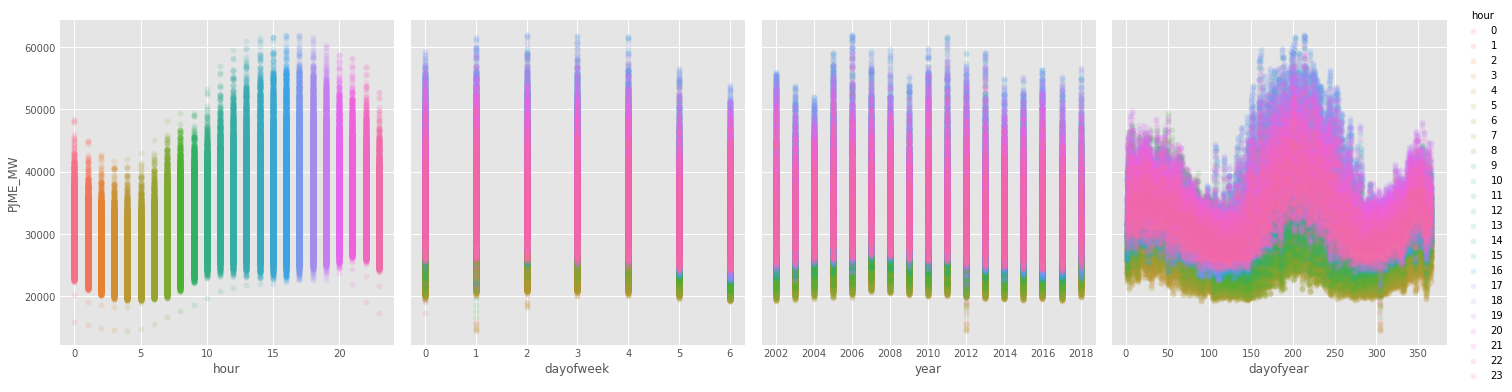

In [63]:
sns.pairplot(features_and_target.dropna(),hue='hour',x_vars=['hour','dayofweek','year','dayofyear'],
             y_vars='PJME_MW',height=5,
             plot_kws={'alpha':0.15, 'linewidth':0})

In [64]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [65]:
print(pjme_train.head())
print(pjme_test.head())

                     PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0
                     PJME_MW
Datetime                    
2015-12-31 01:00:00  24305.0
2015-12-31 02:00:00  23156.0
2015-12-31 03:00:00  22514.0
2015-12-31 04:00:00  22330.0
2015-12-31 05:00:00  22773.0


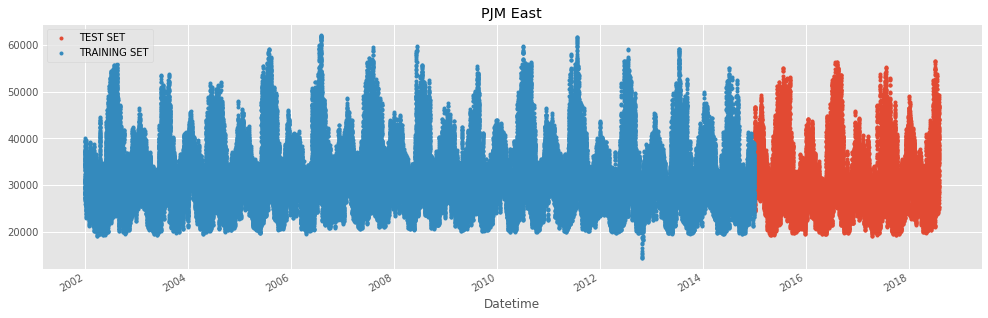

In [66]:
# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

## Simple Prophet Model
Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.

In [67]:
 pjme_train = pjme_train.reset_index().rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})
pjme_train

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
113922,2014-01-01 20:00:00,36193.0
113923,2014-01-01 21:00:00,35601.0
113924,2014-01-01 22:00:00,34242.0
113925,2014-01-01 23:00:00,32215.0


In [68]:
# Setup and train model and fit
model = Prophet()
model.fit(pjme_train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [69]:
# Predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [70]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31214.768254,23954.715804,32689.436291,31214.768254,31214.768254,-2864.261748,-2864.261748,-2864.261748,-4430.327494,-4430.327494,-4430.327494,1281.386957,1281.386957,1281.386957,284.678790,284.678790,284.678790,0.0,0.0,0.0,28350.506505
1,2015-01-01 02:00:00,31214.731338,22433.513754,31341.551872,31214.731338,31214.731338,-4368.619332,-4368.619332,-4368.619332,-5927.219491,-5927.219491,-5927.219491,1272.629269,1272.629269,1272.629269,285.970889,285.970889,285.970889,0.0,0.0,0.0,26846.112005
2,2015-01-01 03:00:00,31214.694422,21364.924627,30335.539791,31214.694422,31214.694422,-5240.326860,-5240.326860,-5240.326860,-6790.297120,-6790.297120,-6790.297120,1262.665752,1262.665752,1262.665752,287.304507,287.304507,287.304507,0.0,0.0,0.0,25974.367562
3,2015-01-01 04:00:00,31214.657506,21127.731845,30526.926892,31214.657506,31214.657506,-5381.914966,-5381.914966,-5381.914966,-6922.214631,-6922.214631,-6922.214631,1251.619994,1251.619994,1251.619994,288.679670,288.679670,288.679670,0.0,0.0,0.0,25832.742540
4,2015-01-01 05:00:00,31214.620591,22161.428009,30822.028498,31214.620591,31214.620591,-4707.617961,-4707.617961,-4707.617961,-6237.342157,-6237.342157,-6237.342157,1239.627794,1239.627794,1239.627794,290.096402,290.096402,290.096402,0.0,0.0,0.0,26507.002630


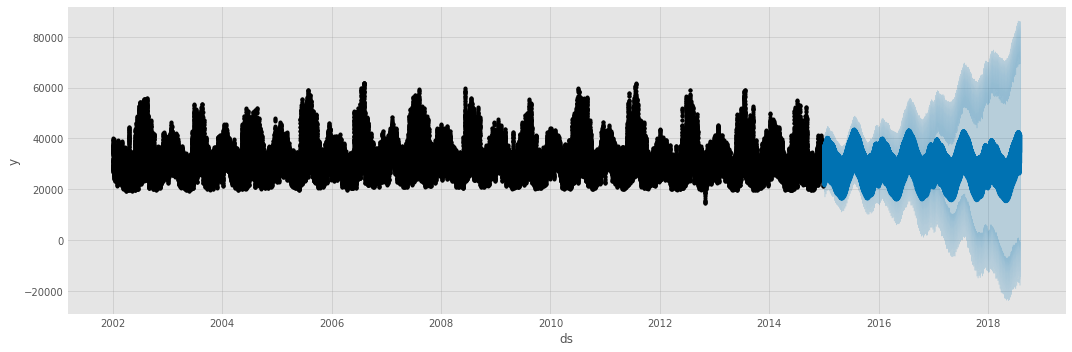

In [71]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

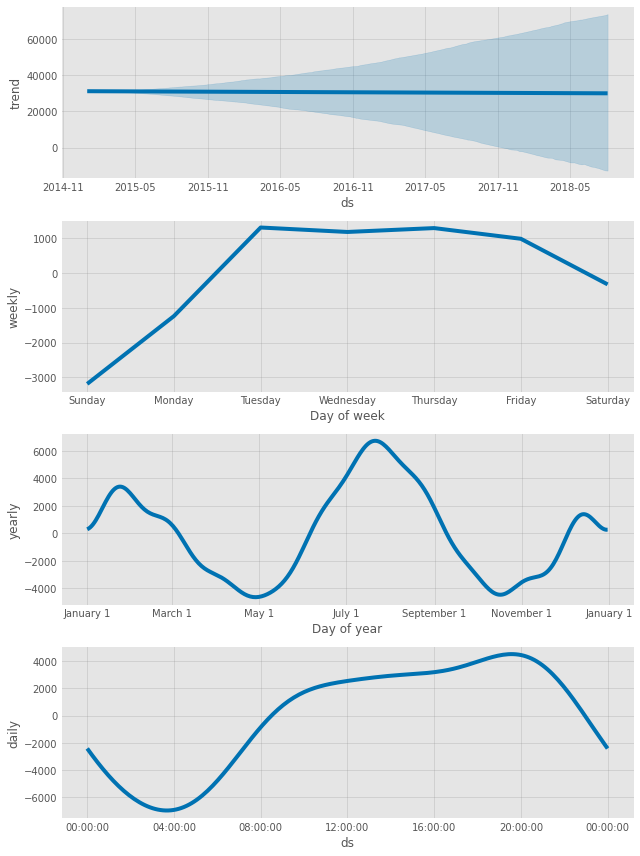

In [72]:
# Plot the components of the model
fig = model.plot_components(pjme_test_fcst)

## Compare Forecast to Actuals

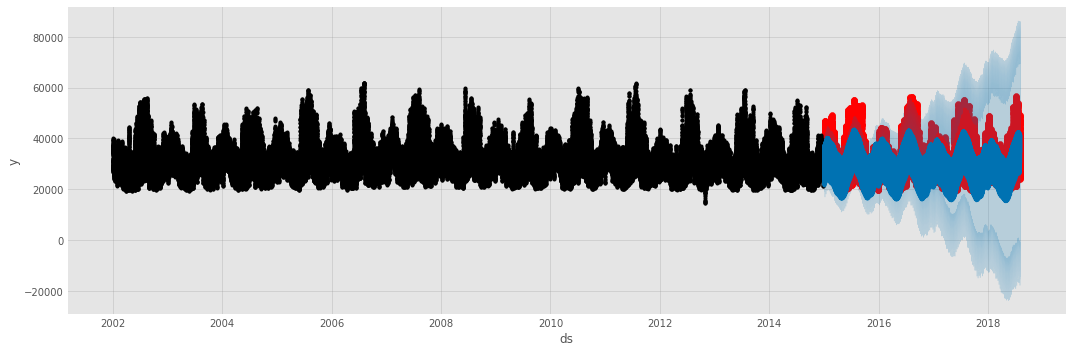

In [73]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

## Look at first month of predictions

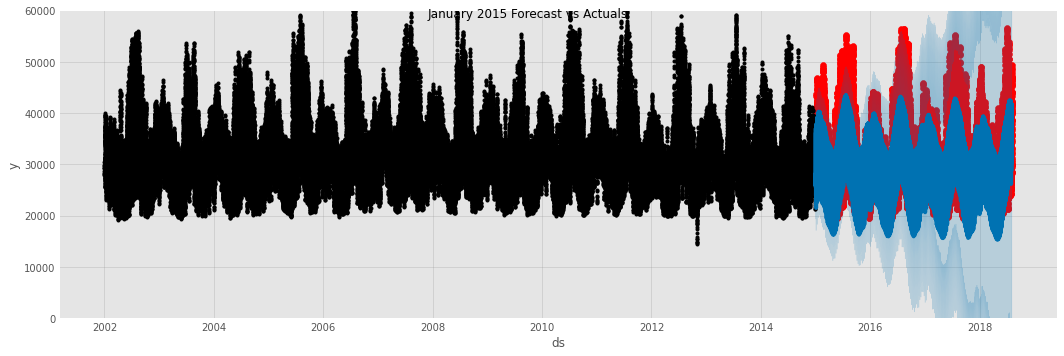

In [74]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

In [98]:
print ("MEAN Squared Error",mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))

print ("MEAN Absolute Error ",mean_absolute_error(y_true=pjme_test['PJME_MW'],
                    y_pred=pjme_test_fcst['yhat']))


MEAN Squared Error 43761675.09158127
MEAN Absolute Error  5181.782050398612


In [76]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_abs_per_error = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],y_pred=pjme_test_fcst['yhat'])
print ("Mean absolute percentage error ",mean_abs_per_error)

Mean absolute percentage error  16.512109913326153


## LSTM for Power prediction

In [77]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,Bidirectional
from tensorflow.keras.layers import BatchNormalization,RepeatVector,TimeDistributed
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

In [78]:
pjme_lstm = pd.read_csv('/content/PJME_hourly.csv',index_col=[0],parse_dates=[0])
pjme_lstm

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [79]:
#checking missing data
pjme_lstm.isna().sum()

PJME_MW    0
dtype: int64

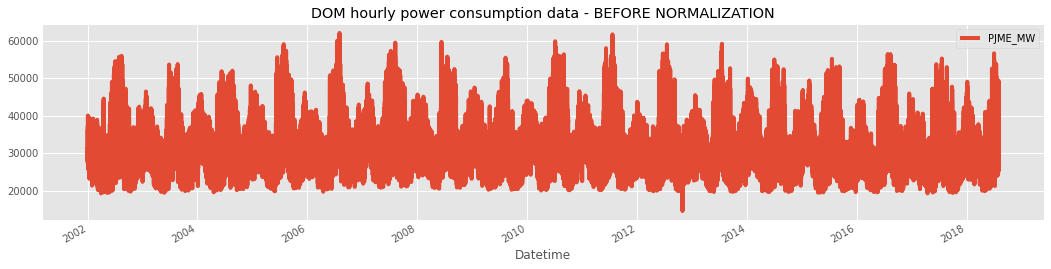

In [80]:
pjme_lstm.plot(figsize=(16,4),legend=True)
plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')
plt.show()

In [81]:
def normalize_data(df):
    df = df.copy()
    scaler = MinMaxScaler()
    column_scaler = {}
    # scale the data (prices) from 0 to 1
    df['PJME_MW_scaler']=scaler.fit_transform(df['PJME_MW'].values.reshape(-1,1))
    return df
pjme_lstm_norm = normalize_data(pjme_lstm)
print(pjme_lstm_norm.shape)


(145366, 2)


In [82]:
pjme_lstm_norm.drop('PJME_MW',inplace=True,axis=1)
pjme_lstm_norm.head()

,PJME_MW_scaler
Datetime,
2002-12-31 01:00:00,0.251849
2002-12-31 02:00:00,0.223386
2002-12-31 03:00:00,0.211314
2002-12-31 04:00:00,0.207500
2002-12-31 05:00:00,0.217339


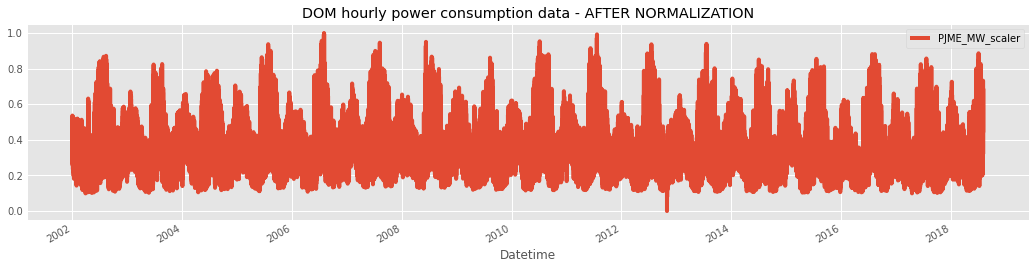

In [83]:
pjme_lstm_norm.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

In [84]:
def load_data(df,seq_length):
    X_train =[]
    y_train = []
    for i in range(seq_length,len(df)):
      X_train.append(df.iloc[i-seq_length:i,0])
      y_train.append(df.iloc[i, 0])
    #1 last 6189 days are going to be used in test
    X_test = np.array(X_train[110000:])
    y_test = np.array(y_train[110000:])
    
    #2 first 110000 days are going to be used in training
    X_train = np.array(X_train[:110000] )
    y_train = np.array(y_train[:110000])

    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_length, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_length, 1))

    return [X_train, y_train, X_test, y_test]

In [85]:
SEQUENCE_LEN = 24
x_train , y_train , x_test, y_test = load_data(pjme_lstm_norm,SEQUENCE_LEN)

In [86]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(110000, 24, 1)
(35342, 24, 1)
(110000,)
(35342,)


In [87]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True,kernel_regularizer=l2(0.01), input_shape=(x_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True,kernel_regularizer=l2(0.01)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 24, 40)            6720      
_________________________________________________________________
dropout_12 (Dropout)         (None, 24, 40)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 24, 40)            12960     
_________________________________________________________________
dropout_13 (Dropout)         (None, 24, 40)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 40)                12960     
_________________________________________________________________
dropout_14 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

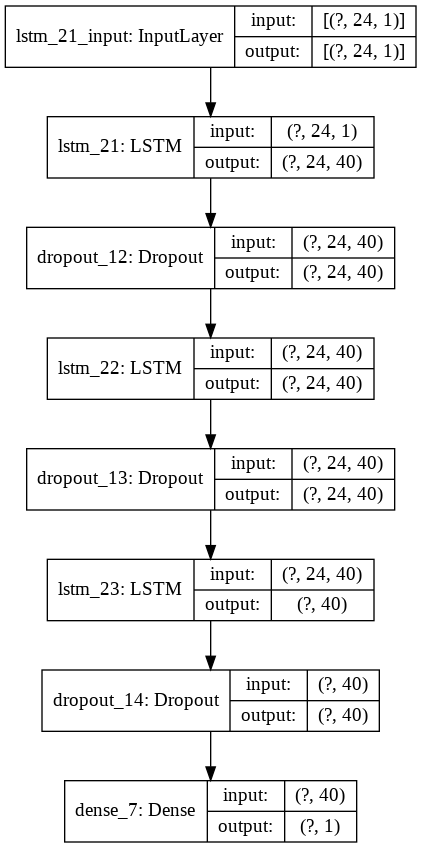

In [88]:
lstm_model.compile(loss='mean_absolute_error',metrics=["mean_absolute_error"], optimizer='rmsprop')
from keras.utils import plot_model
plot_model(lstm_model, show_layer_names=True, show_shapes=True)

In [89]:
import os 
from sklearn.metrics import r2_score
tensorboard = TensorBoard(log_dir=os.path.join("logs", "Power_consumption"))

In [90]:
BATCH_SIZE = 256
EPOCHS = 40
H = lstm_model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,callbacks=[tensorboard],
                    epochs=EPOCHS,validation_split=0.3)

Epoch 1/40
  2/301 [..............................] - ETA: 1:21 - loss: 1.0266 - mean_absolute_error: 0.3742WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0185s vs `on_train_batch_end` time: 0.5229s). Check your callbacks.


301/301 [==============================] - 5s 18ms/step - loss: 0.2045 - mean_absolute_error: 0.0945 - val_loss: 0.0795 - val_mean_absolute_error: 0.0665
Epoch 2/40
301/301 [==============================] - 4s 13ms/step - loss: 0.0694 - mean_absolute_error: 0.0608 - val_loss: 0.0737 - val_mean_absolute_error: 0.0675
Epoch 3/40
301/301 [==============================] - 4s 13ms/step - loss: 0.0612 - mean_absolute_error: 0.0557 - val_loss: 0.0562 - val_mean_absolute_error: 0.0513
Epoch 4/40
301/301 [==============================] - 4s 14ms/step - loss: 0.0574 - mean_absolute_error: 0.0529 - val_loss: 0.0517 - val_mean_absolute_error: 0.0474
Epoch 5/40
301/301 [==============================] - 4s 13ms/step - loss: 0.0546 - mean_absolute_error: 0.0507 - val_loss: 0.0528 - val_mean_absolute_error: 0.0493
Epoch 6/40
301/301 [==============================] - 4s 13ms/step - loss: 0.0529 - mean_absolute_error: 0.0495 - val_loss: 0.0480 - val_mean_absolute_error: 0.0448
Epoch 7/40
301/301 [=

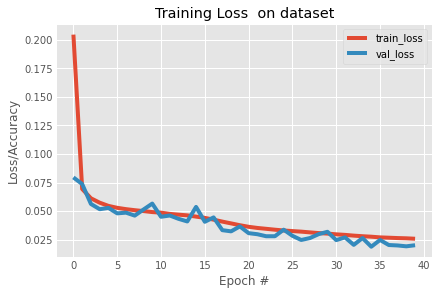

In [91]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")

plt.title("Training Loss  on dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

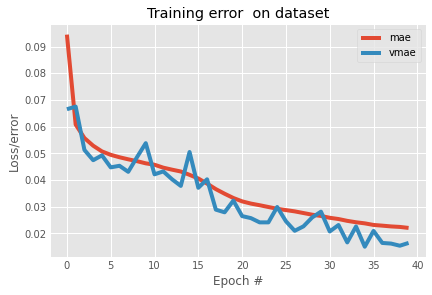

In [92]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["mean_absolute_error"], label="mae")
plt.plot(np.arange(0, N), H.history["val_mean_absolute_error"], label="vmae")
plt.title("Training error  on dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/error")
plt.legend(loc="upper right")
plt.show()

In [100]:
# evaluate the model
mse, mae = lstm_model.evaluate(x_test, y_test, verbose=0)

lstm_predictions = lstm_model.predict(x_test)

# calculate the mean absolute error (inverse scaling)
lstm_score = r2_score(y_test,lstm_predictions)
print("R2 Score of LSTM model = ",lstm_score)


R2 Score of LSTM model =  0.9708196074386981


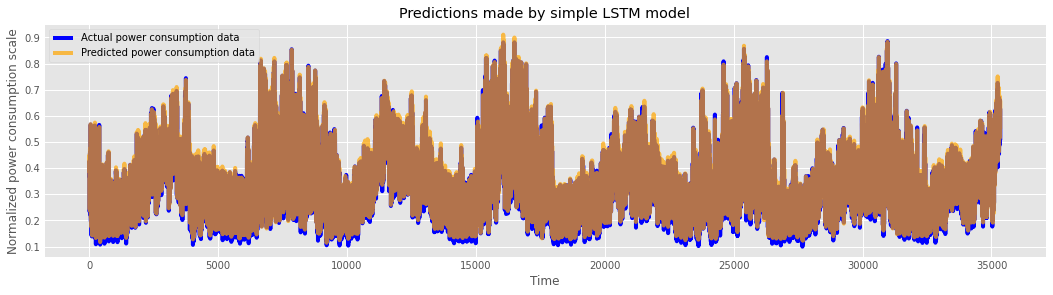

In [101]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple LSTM model")

In [102]:
from tensorflow.keras import Input
from tensorflow.keras import Model 
i = Input(shape=(x_train.shape[1],x_train.shape[2]))
layer1 = Bidirectional(LSTM(512,kernel_regularizer=l2(0.01),return_sequences=True))(i)
layer2 = Bidirectional(LSTM(512,kernel_regularizer=l2(0.01),return_sequences=True))(layer1)
layer3= Bidirectional(LSTM(128,return_sequences=False))(layer2)
output =Dense(1,activation='linear')(layer3)
bider_model = Model(i,output) 
bider_model.compile(loss='mean_absolute_error',metrics=["mean_absolute_error"], optimizer='rmsprop')

In [103]:
bider_model.compile(loss='mean_absolute_error',metrics=["mean_absolute_error"], optimizer='rmsprop')
bider_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 24, 1)]           0         
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 24, 1024)          2105344   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 24, 1024)          6295552   
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 256)               1180672   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 9,581,825
Trainable params: 9,581,825
Non-trainable params: 0
_________________________________________________________________


In [50]:
BATCH_SIZE = 256
EPOCHS = 40
H = bider_model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                   epochs=EPOCHS,
                   validation_split=0.3)

Epoch 1/40
301/301 [==============================] - 28s 94ms/step - loss: 0.9684 - mean_absolute_error: 0.0919 - val_loss: 0.0702 - val_mean_absolute_error: 0.0492
Epoch 2/40
301/301 [==============================] - 27s 89ms/step - loss: 0.0678 - mean_absolute_error: 0.0484 - val_loss: 0.0475 - val_mean_absolute_error: 0.0317
Epoch 3/40
301/301 [==============================] - 27s 89ms/step - loss: 0.0561 - mean_absolute_error: 0.0391 - val_loss: 0.0627 - val_mean_absolute_error: 0.0464
Epoch 4/40
301/301 [==============================] - 27s 90ms/step - loss: 0.0510 - mean_absolute_error: 0.0348 - val_loss: 0.0536 - val_mean_absolute_error: 0.0379
Epoch 5/40
301/301 [==============================] - 27s 89ms/step - loss: 0.0483 - mean_absolute_error: 0.0324 - val_loss: 0.0351 - val_mean_absolute_error: 0.0193
Epoch 6/40
301/301 [==============================] - 27s 89ms/step - loss: 0.0462 - mean_absolute_error: 0.0305 - val_loss: 0.0430 - val_mean_absolute_error: 0.0276
Epoc

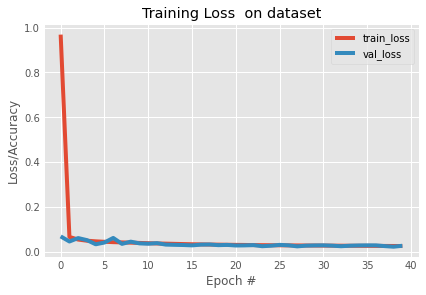

In [51]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")

plt.title("Training Loss  on dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

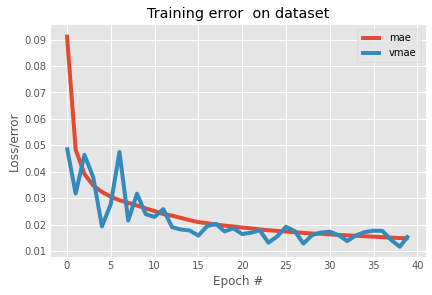

In [52]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["mean_absolute_error"], label="mae")
plt.plot(np.arange(0, N), H.history["val_mean_absolute_error"], label="vmae")
plt.title("Training error  on dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/error")
plt.legend(loc="upper right")
plt.show()

In [56]:
# evaluate the model
mse, mae = bider_model.evaluate(x_test, y_test, verbose=0)

bider_predictions = bider_model.predict(x_test)

# calculate the mean absolute error (inverse scaling)
bider_score = r2_score(y_test,bider_predictions)
print("R2 Score of RNN model = ",bider_score)

R2 Score of RNN model =  0.9701448418337757


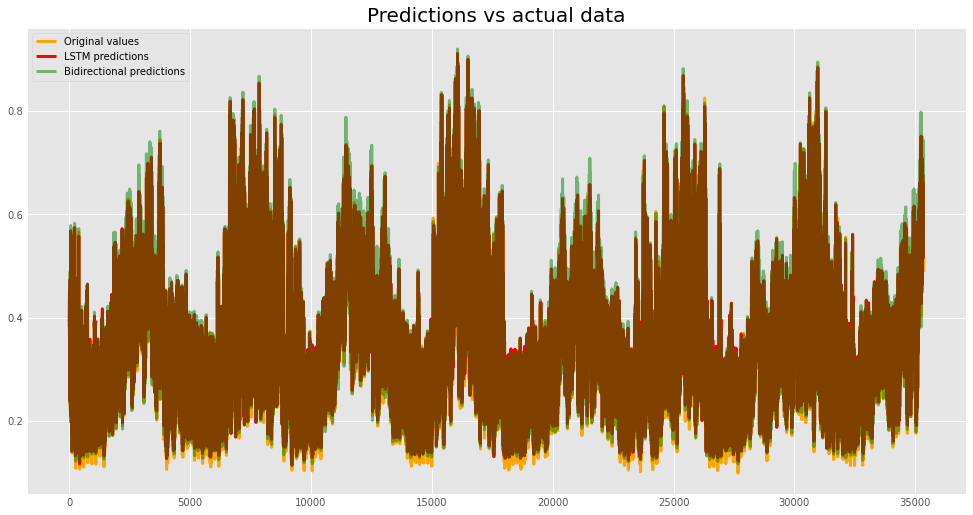

In [105]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(bider_predictions, alpha=0.5, c="green", linewidth=3, label="Bidirectional predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()